In [1]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# # add path to environment in case of plot error
# import os
# os.environ['PROJ_LIB']=r'/home/user/.conda/envs/venvname/share/proj' # path to the proj4 folder.
# os.environ['GDAL_DATA']=r'/home/user/.conda/envs/venvname/share' # path to the proj4 folder.

# Direct access
import s3fs
import earthaccess as ea
import fsspec

# datetime
import datetime as dt

# api to read files: possible packages to use
# import xarray as xr # for netcdf
import h5py  # for hdf5
# import gzip  # for .gz to decompress the file

# data process
import numpy as np
import pandas as pd

# plotting using self-defined functions for better visualization
from plot_function import ndarry_mask  # mask the array
from plot_function import map_plot  # plot the map
import matplotlib.pyplot as plt


In [2]:
# defined function to print the structure of the file
def h5printR(item, leading = ''):
    for key in item:
        if isinstance(item[key], h5py.Dataset):
            print(leading + key + ': ' + str(item[key].shape))
        else:
            print(leading + key)
            h5printR(item[key], leading + '  ')

In [3]:
auth = ea.login(strategy="netrc", persist=True) # use 'interactive' strategy the first time to log in

You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/15/2023
Using .netrc file for EDL


In [4]:
#### dataset2 in ASCII format with compression ####

# step1: provdie the daac name and short name of dataset
    # define the name of daac and dataset
DAAC1 = 'GES_DISC'
ssh_short_name1 = "GPM_3IMERGHHL" # short name of dataset. 

# step2: get links #
results1 = ea.search_data(
    short_name=ssh_short_name1,
    cloud_hosted=True,
    temporal=("2015-05-16", "2015-05-17"),
)

    # data_link list
https_links1 = []  # external link, todo: find ways to directly access data using external link
s3_links1 = []  # s3 link to directly accessing  data in AWS

for granule in results1:
    https_links1.extend(granule.data_links(access="on_prem"))
    s3_links1.extend(granule.data_links(access="direct"))
    
# step3: select proper links for use (similar part to what we did when we worked in local enviroment)


Granules found: 49


In [5]:
s3_links1 # time resolution: half-hourly  

['s3://gesdisc-cumulus-prod-protected/GPM_L3/GPM_3IMERGHHL.06/2015/136/3B-HHR-L.MS.MRG.3IMERG.20150516-S000000-E002959.0000.V06B.HDF5',
 's3://gesdisc-cumulus-prod-protected/GPM_L3/GPM_3IMERGHHL.06/2015/136/3B-HHR-L.MS.MRG.3IMERG.20150516-S003000-E005959.0030.V06B.HDF5',
 's3://gesdisc-cumulus-prod-protected/GPM_L3/GPM_3IMERGHHL.06/2015/136/3B-HHR-L.MS.MRG.3IMERG.20150516-S010000-E012959.0060.V06B.HDF5',
 's3://gesdisc-cumulus-prod-protected/GPM_L3/GPM_3IMERGHHL.06/2015/136/3B-HHR-L.MS.MRG.3IMERG.20150516-S013000-E015959.0090.V06B.HDF5',
 's3://gesdisc-cumulus-prod-protected/GPM_L3/GPM_3IMERGHHL.06/2015/136/3B-HHR-L.MS.MRG.3IMERG.20150516-S020000-E022959.0120.V06B.HDF5',
 's3://gesdisc-cumulus-prod-protected/GPM_L3/GPM_3IMERGHHL.06/2015/136/3B-HHR-L.MS.MRG.3IMERG.20150516-S023000-E025959.0150.V06B.HDF5',
 's3://gesdisc-cumulus-prod-protected/GPM_L3/GPM_3IMERGHHL.06/2015/136/3B-HHR-L.MS.MRG.3IMERG.20150516-S030000-E032959.0180.V06B.HDF5',
 's3://gesdisc-cumulus-prod-protected/GPM_L3/GPM

In [10]:
# step4: get credentials and open files with credentials #
s3_fs1 = ea.get_s3fs_session(DAAC1) # valid in one hour, need to refresh automatically for longer access

#### read hdf5 data ####
# open files with s3 links, works only in AWS #
with s3_fs1.open(s3_links1[33], mode='rb') as f1: # open files with s3 links 5:00pm
    with h5py.File(f1) as hdf5:
        h5printR(hdf5)

Grid
  nv: (2,)
  lonv: (2,)
  latv: (2,)
  time: (1,)
  lon: (3600,)
  lat: (1800,)
  time_bnds: (1, 2)
  lon_bnds: (3600, 2)
  lat_bnds: (1800, 2)
  precipitationCal: (1, 3600, 1800)
  precipitationUncal: (1, 3600, 1800)
  randomError: (1, 3600, 1800)
  HQprecipitation: (1, 3600, 1800)
  HQprecipSource: (1, 3600, 1800)
  HQobservationTime: (1, 3600, 1800)
  IRprecipitation: (1, 3600, 1800)
  IRkalmanFilterWeight: (1, 3600, 1800)
  probabilityLiquidPrecipitation: (1, 3600, 1800)
  precipitationQualityIndex: (1, 3600, 1800)


In [11]:
#### read hdf5 data ####
# open files with s3 links, works only in AWS #
with s3_fs1.open(s3_links1[0], mode='rb') as f1: # open files with https links
    with h5py.File(f1) as hdf5:
        lon = hdf5['Grid']['lon'][:]
        lat = hdf5['Grid']['lat'][:]
        date_time = hdf5['Grid']['time_bnds'][:]
        precip = hdf5['Grid']['precipitationCal'][:]

In [12]:
# replace -9999.9 with nan
precip = precip[0,:,:]
precip[precip == -9999.9] = np.nan
precip[precip == 0] = np.nan
precip = np.transpose(precip)
precip.shape

(1800, 3600)

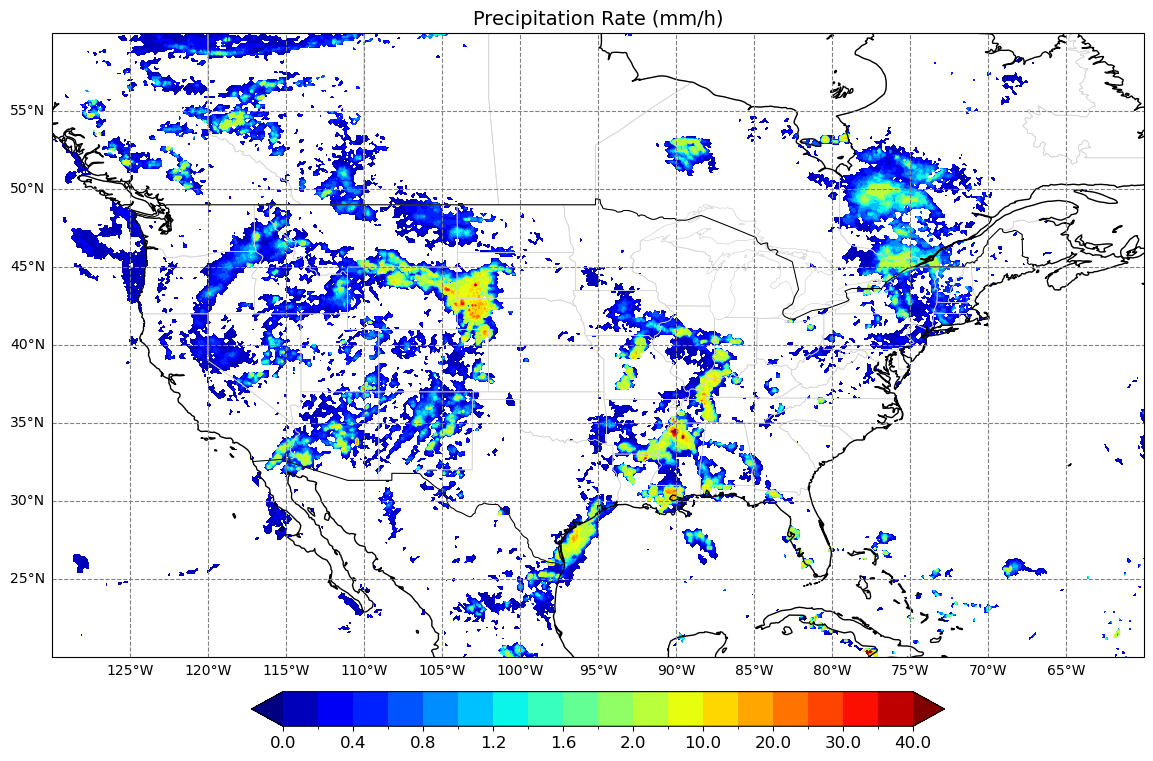

In [13]:
# plot the data
# data_masked = ndarry_mask(x_coor, y_coor, ascii_grid, country_point=[-98.5, 39.8])  # flip the mask to match the data
x_coor = lon
y_coor = lat
data_masked = precip
bounds = [0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 5, 10, 15, 20, 25, 30, 35, 40]
c_map = 'jet'
zoom_region = [-129.995, -60.00500000000001, 20.005, 54.995000000000005]

fig1, main_ax1, cbar1 = map_plot(x_coor, y_coor, data_masked, bounds=bounds, c_map=c_map,zoom_region = zoom_region)
main_ax1.set_title('Precipitation Rate (mm/h)', fontsize=14)
plt.show()